# SYDE 552 Assignmnet 4: Neuron Models
### Due Monday, March 9, 11:59pm
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with neuron models of various complexitites. To do so, we'll be using the BRIAN2 neural simulator, a user-friendly Python library which for creating arbitrary spiking neuron models from scratch. We'll provide a basic tutorial for BRIAN that should include everything needed to do this assigment, but for additional help and existing neuron implmenetations, see the links below. 

Work in groups of 1-2 people. Your code should be original, but you can borrow ideas and equations from these sources when building your models (please note when you do). Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

Additional sources
 - Equations: Dayan and Abbott Ch.5-6, Gerstner et al Ch.1-2
 - BRIAN2 documentation: https://brian2.readthedocs.io/en/stable/index.html
 - Working examples: https://brian2.readthedocs.io/en/stable/resources/tutorials/index.html, https://brian2.readthedocs.io/en/stable/user/multicompartmental.html, https://neuronaldynamics-exercises.readthedocs.io/en/latest/

# Install and Import Libraries


Install BRIAN2 (https://brian2.readthedocs.io/en/stable/introduction/install.html). You'll also need jupyter, numpy, (scipy), and matplotlib. I reccomend using ```pip``` to install everything: from a terminal, just run

```pip intall brian2```

```pip intall jupyter numpy scipy matplotlib```


open this jupyter notebook with 

```jupyter notebook syde552assigment4.ipynb```

In [1]:
import numpy as np
import scipy
from brian2 import *
import matplotlib.pyplot as plt

# Intro to BRIAN2 (integrate-and-fire models)
BRIAN uses a unit system to give the constants in neuron equations appropriate physical dimensions

In [2]:
v_demo = -65*mV  # voltage
print(v_demo)

-65. mV


BRIAN does unit combinations, but will tell you when units don't match up

In [9]:
r_demo = 10*ohm  # resistance
i_demo = v_demo/r_demo  # calculate current
print(i_demo)

-6.5 mA


In [5]:
v_demo + i_demo  # volts + amps = (invalid) - should produce a DimensionMismatchError

DimensionMismatchError: Cannot calculate -65. mV + -6.5 mA, units do not match (units are V and A).

Equations are written as strings, adding a ```: unit``` at the end

In [10]:
tau = 10*ms
eqn = '''dv/dt = -v/tau : mV'''

Note that ```mV``` describes the unit defined by the equation, not the quantity on the left-hand-side (which would here be mV/s).

Just type ```: 1``` to ignore units

In [11]:
eqn = '''
dv/dt = (1-v)/tau: 1  # leak towards v_eq=1 
'''

Create a neuron by defining an "ensemble" (population) of neurons

In [12]:
ens = NeuronGroup(1, eqn, method='exact')  # n=1 neurons in the population, "exact" numerical integration

Set up a probe to record state variables from neurons in ```ens```

In [13]:
p = StateMonitor(ens, 'v', record=True)

Run the simulation

In [14]:
run(100*ms)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Plot the result

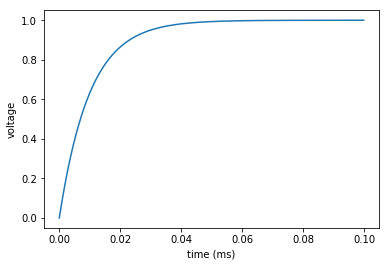

In [15]:
fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])  # measuring from the first neuron in "ens" [index=0]
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.show()

Add in a spiking mechanism, which includes a "threshold" and a "reset" mechanism.

The ```threshold``` block defines the condition which must be met to register a "spike".

The ```reset``` block defines what happens when a spike occurs.

Before we start, let's explicitly create a scope for this particular model. This avoids accidentally carrying over from variables / constants defined earlier in the notebook.

In [376]:
start_scope()

tau = 10*ms
v_target = 10*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''dv/dt = (v_target - v)/tau : volt'''

ens = NeuronGroup(1, eqn, threshold='v>theta', reset='v = v_reset', method='euler')

Notice that we started using real units, and changed our numerical integration scheme to a simple numerical solver (Euler's Method)

We also need to define a new type of probe to collect spikes

In [377]:
p = StateMonitor(ens, 'v', record=True)
p_s = SpikeMonitor(ens)

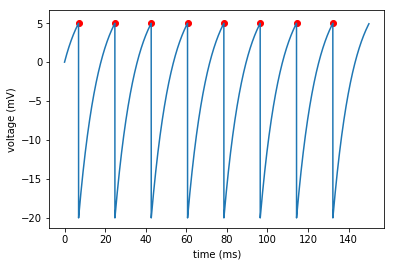

In [380]:
run(50*ms)

fig, ax = plt.subplots()
ax.plot(p.t / ms, p.v[0] / mV)
ax.scatter(p_s.t / ms, theta / mV *np.ones((len(p_s.t))), color='r')
ax.set(xlabel='time (ms)', ylabel='voltage (mV)')
plt.show()

Reset and refractory mechanisms can also be specified as complex expressions, each defined by its own string.

We'll add a unitless state variable ```a``` that is incremented when a spike occurs, and increases the spike threshold and the refractor period

WARNING    "a" is an internal variable of group "neurongroup_4", but also exists in the run namespace with the value array([-0.75, -0.66, -0.59, ..., -0.8 , -0.8 , -0.8 ]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


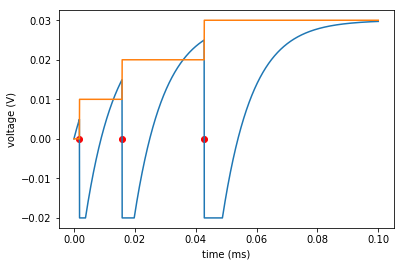

In [381]:
start_scope()

tau = 10*ms
v_target = 30*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''
dv/dt = (v_target - v)/tau : volt  (unless refractory)
a : 1  # unitless
'''

thr = '''v > theta + a*volt'''  # convert a to volts to allow addition

rst = '''
v = v_reset
a += 0.01
'''

ref = '''a*200*ms'''

ens = NeuronGroup(1, eqn, threshold=thr, reset=rst, refractory=ref, method='euler')

p_v = StateMonitor(ens, 'v', record=True)
p_a = StateMonitor(ens, 'a', record=True)
p_s = SpikeMonitor(ens)

run(100*ms)

fig, ax = plt.subplots()
ax.plot(p_v.t, p_v.v[0])
ax.plot(p_a.t, p_a.a[0])
ax.scatter(p_s.t, np.zeros((p_s.t.shape)), color='r')
ax.set(xlabel='time (ms)', ylabel='voltage (V)')
plt.show()

# Question 1: LIF Neuron

## 1.1 [2 points] Implement the LIF neuron. Simulate the neuron with a 10mA external current. Plot voltage vs time.

#### Equations: 
$\frac{dV}{dt} = -\frac{1}{\tau_{RC}}(V - E_{leak}) + I_{ext}$

if $V>V_{thr}$:
- set $V=V_{reset}$
- begin a refractory period of $\tau_{ref}$ ms
 
#### Constants:
 - $R = 10$ ohm
 - $C = 1$ mfarad
 - $\tau_{ref} = 2$ ms
 - $E_{leak} = -65$ mV
 - $V_{thr} = -50$ mV
 - $V_{reset} = -80$ mV
 - $I_{ext} = 2$ mA
 
#### Notes
 - set state variables using ```ens.v = v_initial```

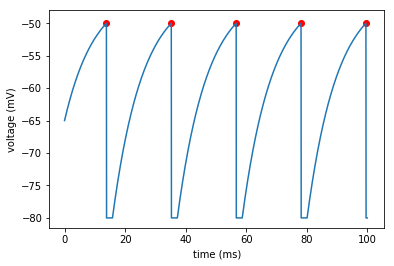

In [383]:
start_scope()

# constant 
R = 10 *ohm
C = 1 *mfarad
tau_m = R * C

E_leak = -65 *mV
tau_ref = 2 *ms
theta = -50 *mV
v_reset = -80 *mV
I = 2 *mA

# eqn
eqn = '''dv/dt = (-(v - E_leak) + I * R) / tau_m  :  volt (unless refractory)'''

thr = 'v > theta'
rst = 'v = v_reset'
ref = 'tau_ref'

# ens
ens = NeuronGroup(1, eqn, threshold = thr, reset = rst, refractory = ref, method = 'euler')
v_initial = E_leak
ens.v = v_initial

# prob
p_v = StateMonitor(ens, 'v', record=True)
p_s = SpikeMonitor(ens)

# run
run(100*ms)

# figure
fig, ax = plt.subplots()
ax.plot(p_v.t / ms, p_v.v[0] / mV)
ax.scatter(p_s.t / ms, theta / mV * np.ones((p_s.t.shape)), color='r')
ax.set(xlabel = 'time (ms)', ylabel = 'voltage (mV)')
plt.show()

## 1.2 [2 points] Create response curves for the LIF neuron
 - (a) Inject a constant test current into the neuron, run the simulation, and count the number of spikes. Repeat this for a variety of test currents, then plot average firing rate (spikes/second) versus input current.
 - (b) Choose a new value of R or C, run the experiment from (a) again, and add the new response curve to your plot
 - (c) Choose a new value of tau_ref, run the experiment from (a) again, and overlay the new resopnse curve to your plot

#### Parameters
- Test currents: 1-20mA in increments of 0.5mA
- Simulation duration: $200$ms

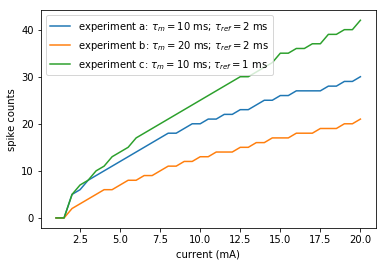

In [3]:
R1 = 10 *ohm
C1 = 1 *mfarad
tau_ref1 = 2 *ms
R2 = 10 *ohm
C2 = 2 *mfarad
tau_ref2 = 1 *ms

def LIF_response(I, R, C, tau_ref):
    start_scope()
    
    E_leak = -65 *mV
    theta = -50 *mV
    v_reset = -80 *mV
    tau_m = R * C
    
    eqn = '''dv/dt = (-(v - E_leak) + I * R) / tau_m  :  volt (unless refractory)'''

    thr = 'v > theta'
    rst = 'v = v_reset'
    ref = 'tau_ref'
    ens = NeuronGroup(1, eqn, threshold = thr, reset =rst, refractory = ref, method = 'euler')
    v_initial = E_leak
    ens.v = v_initial
    
    p_s = SpikeMonitor(ens)
    
    run(100*ms)
        
    spike_count = len(p_s.t)
    return (spike_count)
    
I = np.arange(1, 20.5, 0.5) *mA  
spike_counts_a = []
spike_counts_b = []
spike_counts_c = []

for i in range(len(I)):
    spike_counts_a.append(LIF_response(I[i], R1, C1, tau_ref1))

for i in range(len(I)):
    spike_counts_b.append(LIF_response(I[i], R2, C2, tau_ref1))

for i in range(len(I)):
    spike_counts_c.append(LIF_response(I[i], R1, C1, tau_ref2))

# plot spike_counts_a, spike_counts_b, spike_counts_c
plt.plot(I / mA, spike_counts_a, label = r'experiment a: $\tau_m = 10$ ms; $\tau_{ref} = 2$ ms')
plt.plot(I / mA, spike_counts_b, label = r'experiment b: $\tau_m = 20$ ms; $\tau_{ref} = 2$ ms')
plt.plot(I / mA, spike_counts_c, label = r'experiment c: $\tau_m = 10$ ms; $\tau_{ref} = 1$ ms')
plt.xlabel('current (mA)'), plt.ylabel('spike counts')
plt.legend()

## 1.3 [2 points] Add an adaptation term to the LIF neuron. Calculate the inter-spike-interval and plot it versus spike number to demonstrate adaptation.
 - Inter-spike-interval (ISI) is defined as the length of time between two spikes. To calculate it, compute the difference between the spike times returned from a BRIAN spike monitor
   - tip: use ```np.diff()```
 - Plot the resulting array of values as a scatter plot: $y$ values will be ISI in ms, and $x$ values will range from $1$ to $C$, the spike count value at the end of the simulation.

#### Additional Equations
$\frac{da}{dt} = -\frac{a}{\tau_a}$

$v_{thr} = -50mV + a$

if $v > v_{thr}$:
  - $a = a + \Delta A$
  
#### Additional Constants
- $I_{ext} = 2$mA
- $\tau_a = 100$ ms
- $\Delta A = 1$ mV
- runtime = 500 ms

Text(0, 0.5, 'adaptive state (a)')

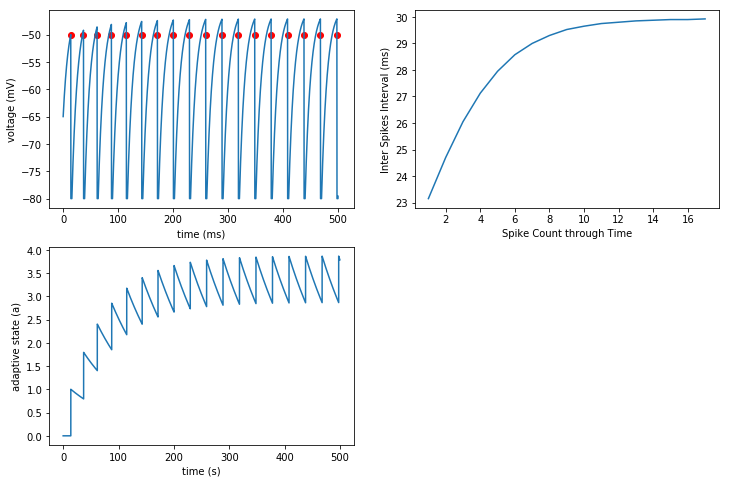

In [6]:
# your solution here
start_scope()

# constant 
R = 10 *ohm
C = 1 *mfarad
tau_m = R * C
tau_a = 100 *ms
E_leak = -65 *mV
tau_ref = 2 *ms
theta = -50 *mV
v_reset = -80 *mV
I = 2 *mA

eqn = '''
dv/dt = (-(v - E_leak) + I * R) / tau_m : volt  (unless refractory)
da / dt = -a / tau_a : 1  # unitless
'''

thr = 'v > theta + a *volt'  # convert a to volts to allow addition

rst = '''
v = v_reset
a += 0.001
'''

ref = 'tau_ref'

ens = NeuronGroup(1, eqn, threshold = thr, reset = rst, refractory = ref, method='euler')
v_initial = E_leak
ens.v = v_initial

p_v = StateMonitor(ens, 'v', record=True)
p_a = StateMonitor(ens, 'a', record=True)
p_s = SpikeMonitor(ens)

run(500 *ms)

ISI_1_3 = np.diff(p_s.t)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(p_v.t / ms, p_v.v[0] / mV)
plt.scatter(p_s.t / ms, theta / mV * np.ones((p_s.t.shape)), color='r')
plt.xlabel('time (ms)'), plt.ylabel('voltage (mV)')

plt.subplot(2,2,2)
C = len(p_s.t)
x_1_3 = np.arange(1, C, 1)
plt.plot(x_1_3, ISI_1_3 / ms)
plt.xlabel('Spike Count through Time'), plt.ylabel('Inter Spikes Interval (ms)')

plt.subplot(2,2,3)
plt.plot(p_a.t / ms, p_a.a[0] / mV)
plt.xlabel('time (s)'); plt.ylabel('adaptive state (a)')

## [Bonus] 1.4 [1 point] Read about other extensions to the LIF model, such as quadratic- or exponential-integrate-and fire. Implement that neuron model, then
 - (a) plot the voltage trace
 - (b) plot the response curve
 - (c) plot spike adaptation

#### exponential-integrate-and fire neuron

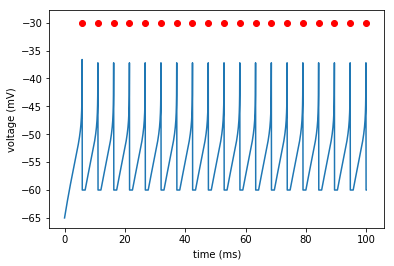

In [388]:
start_scope()

# constant 
R = 20.0 *Mohm
tau_m = 12.0 *ms 
DeltaT = 2.0 *mV

E_leak = -65.0 *mV
tau_ref = 1 *ms
theta = -30 *mV     #Spiking threshold
v_reset = -60 *mV
v_rheobase = -55.0 *mV    #rheobase threshold
I = 2 *nA

# eqn
# 

eqn = '''dv/dt = (-(v - E_leak) + I * R + DeltaT * exp((v - v_rheobase) / DeltaT)) / tau_m  :  volt (unless refractory)'''

thr = 'v > theta'
rst = 'v = v_reset'
ref = 'tau_ref'

# ens
ens = NeuronGroup(1, eqn, threshold = thr, reset = rst, refractory = ref, method = 'euler')
v_initial = E_leak
ens.v = v_initial

# prob
p_v = StateMonitor(ens, 'v', record=True)
p_s = SpikeMonitor(ens)

# run
run(100*ms)

# figure
fig, ax = plt.subplots()
ax.plot(p_v.t / ms, p_v.v[0] / mV)
ax.scatter(p_s.t / ms, theta /mV * np.ones((p_s.t.shape)), color='r')
ax.set(xlabel = 'time (ms)', ylabel = 'voltage (mV)')
plt.show()

#### adaptive exponential-integrate-and fire neuron

Text(0, 0.5, 'adaptive state (w)')

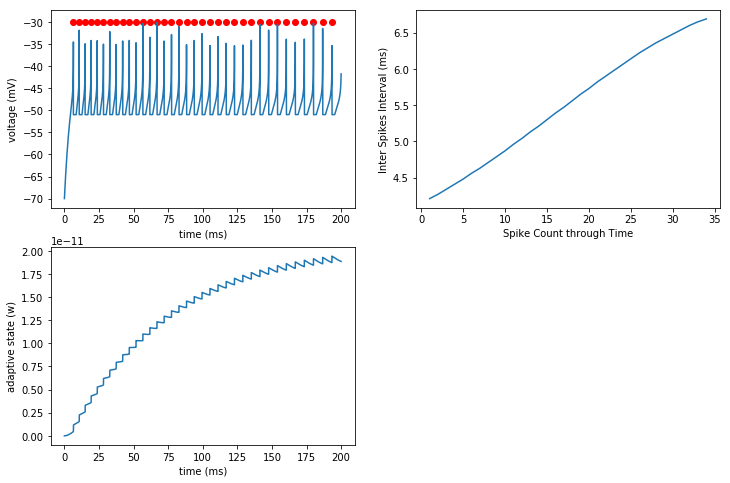

In [425]:
start_scope()

# constant 
R = 500.0 *Mohm
tau_m = 5.0 *ms 
tau_w = 100.0 *ms
DeltaT = 2.0 *mV

E_leak = -70.0 *mV  # also known as v_rest
tau_ref = 2 *ms
theta = -30 *mV     #Spiking threshold
v_reset = -51 *mV
v_rheobase = -50.0 *mV    #rheobase threshold
a = 0.5 *nS
b = 0.7 *pA

I = 65 *pA



# eqn
# 

eqn = '''
    dv / dt = (-(v - E_leak) + I * R - R * w + DeltaT * exp((v - v_rheobase) / DeltaT)) / tau_m  :  volt (unless refractory)
    dw / dt=(a*(v-E_leak)-w)/tau_w : amp
    '''

thr = 'v > theta'

rst = '''
v = v_reset
w += b
'''

ref = 'tau_ref'

# ens
ens = NeuronGroup(1, eqn, threshold = thr, reset = rst, refractory = ref, method = 'euler')
v_initial = E_leak
ens.v = v_initial
ens.w = 0.0 * pA

p_v = StateMonitor(ens, 'v', record=True)
p_w = StateMonitor(ens, 'w', record=True)
p_s = SpikeMonitor(ens)

# run
run(200*ms)

# figure
ISI = np.diff(p_s.t)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(p_v.t / ms, p_v.v[0] / mV)
plt.scatter(p_s.t / ms, theta / mV * np.ones((p_s.t.shape)), color='r')
plt.xlabel('time (ms)'), plt.ylabel('voltage (mV)')

plt.subplot(2,2,2)
C = len(p_s.t)
x = np.arange(1, C, 1)
plt.plot(x, ISI / ms)
plt.xlabel('Spike Count through Time'), plt.ylabel('Inter Spikes Interval (ms)')

plt.subplot(2,2,3)
plt.plot(p_w.t / ms, p_w.w[0])
plt.xlabel('time (ms)'); plt.ylabel('adaptive state (w)')

# Question 2: Wilson Neuron
In his 1999 paper "Simplified dynamics of human and mammalian neocortical neurons", Wilson reduced the Hodgkin-Huxley model down to three coupled differential equations. He showed that this neuron model reproduced action potential dynamics and other electrophysiological measures without any artificial reset mechanisms.

- $\tau_v \frac{dv}{dt} = -(17.81 + 47.58v + 33.80v^2)(v - 0.48) - 26r(v + 0.95) - 13h(v + 0.95) + I_{ext}$
- $\tau_r \frac{dr}{dt} = -r + 1.29v + 0.79 + 3.30(V + 0.38)^2$
- $\tau_h \frac{dh}{dt} = -h + 11(v + 0.754)*(v + 0.69)$

where $v$ is voltage, $r$ is a recovery variable, and $h$ is a conductance variable.

- $\tau_v = 0.97$ms
- $\tau_r = 5.6$ms
- $\tau_H = 99.0$ms
- $dt = 0.05$ms

## 2.1 [2 points] Implement the Wilson Neuron.  Produce an action potential by injecting an external current (I=3 for 0.1ms). Plot voltage vs time. How does the shape of the action potential compare to observed electrophysiology?

#### Tips:
 - Units are weirdly defined in this model: ```v``` varies between $-0.9$ and $0.3$, and time constants are given in seconds. It's easiest to just make the state variables unitless (e.g.```dv/dt = ... : 1```)
 - set the simulation timestep using ```defaultclock.dt = 0.025*ms```
 - set initial conditions to keep the neuron from firing a transient spike at simulation startup:
  - $v_0=-0.75$
  - $r_0=0.2$
 - use ```v**2``` to write powers in an ```eqn=''' ... '''``` block, not ```v^2```
 - run the simulation long enough to observe the full recovery period

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


(Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (V)'))

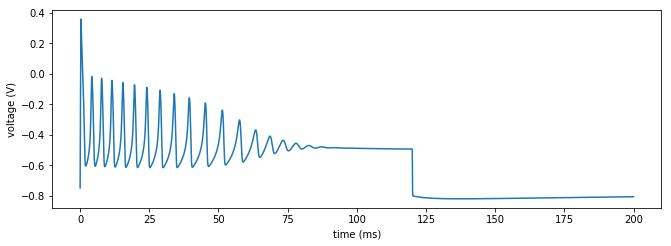

In [3]:
start_scope()

tau_v = 0.97 *ms
tau_r = 5.6 *ms
tau_h = 99.0 *ms
defaultclock.dt = 0.025 *ms

t_end = 120 *ms 
tt = [3 for i in range(int(t_end / defaultclock.dt) + 1)]+[0]
I = TimedArray(tt , dt = defaultclock.dt) 

eqn ='''
    dv / dt = (-(17.81 + 47.58 * v + 33.80 * v ** 2) * (v - 0.48) - 26 * r * (v + 0.95) - 13 *h * (v + 0.95) + I(t)) / tau_v : 1
    dr / dt = (-r + 1.29 * v + 0.79 + 3.30 * (v + 0.38) ** 2) / tau_r : 1
    dh / dt = (-h + 11 * (v + 0.754) * (v + 0.69)) / tau_h : 1
    '''
ens = NeuronGroup(1, eqn, method = 'euler')
ens.v = -0.75 
ens.r = 0.2

p_v = StateMonitor(ens, 'v', record=True)

# run
run(200 *ms)

plt.figure(figsize=(24, 8))
plt.subplot(2,2,1)
plt.plot(p_v.t / ms, p_v.v[0])
plt.xlabel('time (ms)'), plt.ylabel('voltage (V)')

##### Observation on Welson Neuron
- The action potential shows adaptation. That is ISI increases as the neuron keeps firing spikes.
- Another pattern observed is burst firing. After a period of rapid firing, the neuron stops firing, despite the existance of the external current.Finally, the memberane potential approaches to specific constant voltage (proportinal to $I_{ext}$.)  
- When we stop injecting current, the neuron's memberane returns to resting potential. 

### 2.2 [1 point] Coupled ODEs in complex neuron models are numerically sensitive, and the system can explode under certain conditions. Show that increasing the timestep or injecting a powerful, sustained current produces unrealistic voltage traces.

#### (a) Sytem numerical explosion: increasing timestep

WARNING    <string>:25: RuntimeWarning: overflow encountered in multiply
 [py.warnings]
WARNING    <string>:24: RuntimeWarning: invalid value encountered in add
 [py.warnings]
WARNING    <string>:25: RuntimeWarning: invalid value encountered in subtract
 [py.warnings]


(Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (V)'))

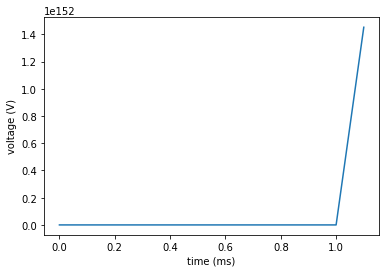

In [373]:
start_scope()

tau_v = 0.97 *ms
tau_r = 5.6 *ms
tau_h = 99.0 *ms
defaultclock.dt = 0.1 *ms

t_end = 100 *ms 
tt = [3 for i in range(int(t_end / defaultclock.dt) + 1)]+[0]
I = TimedArray(tt , dt = defaultclock.dt) 

eqn ='''
    dv / dt = (-(17.81 + 47.58 * v + 33.80 * v ** 2) * (v - 0.48) - 26 * r * (v + 0.95) - 13 *h * (v + 0.95) + I(t)) / tau_v : 1
    dr / dt = (-r + 1.29 * v + 0.79 + 3.30 * (v + 0.38) ** 2) / tau_r : 1
    dh / dt = (-h + 11 * (v + 0.754) * (v + 0.69)) / tau_h : 1
    '''
ens = NeuronGroup(1, eqn, method = 'euler')
ens.v = -0.75 
ens.r = 0.2

p_v_ = StateMonitor(ens, 'v', record=True)

# run
run(200 *ms)

plt.plot(p_v_.t * 1000, p_v_.v[0])
plt.xlabel('time (ms)'), plt.ylabel('voltage (V)')

#### (b) Sytem numerical explosion: powerful input

(Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (V)'))

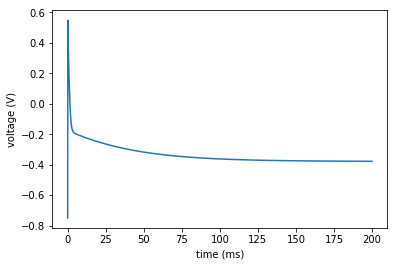

In [374]:
start_scope()

tau_v = 0.97 *ms
tau_r = 5.6 *ms
tau_h = 99.0 *ms
defaultclock.dt = 0.025 *ms

I = 10

eqn ='''
    dv / dt = (-(17.81 + 47.58 * v + 33.80 * v ** 2) * (v - 0.48) - 26 * r * (v + 0.95) - 13 *h * (v + 0.95) + I) / tau_v : 1
    dr / dt = (-r + 1.29 * v + 0.79 + 3.30 * (v + 0.38) ** 2) / tau_r : 1
    dh / dt = (-h + 11 * (v + 0.754) * (v + 0.69)) / tau_h : 1
    '''
ens = NeuronGroup(1, eqn, method = 'euler')
ens.v = -0.75 
ens.r = 0.2

p_v_ = StateMonitor(ens, 'v', record=True)

# run
run(200 *ms)

plt.plot(p_v_.t * 1000, p_v_.v[0])
plt.xlabel('time (ms)'), plt.ylabel('voltage (V)')

## 2.3 [1 point] Show the Wilson neuron exhibits spike adaptation by plotting ISI versus spike number. How does this adaptation compare to the adaptive LIF neuron from Question 1.3?

#### Note
- you will need to think of a good way to define a "spike" for continuous voltages

(Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (V)'))

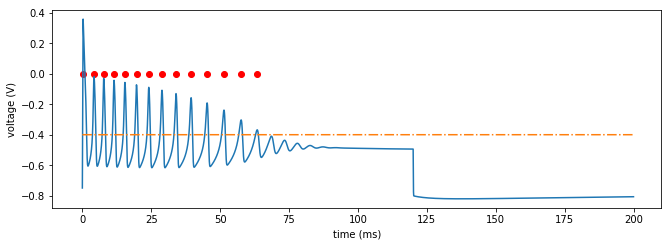

In [4]:
spike_times = []
theta = -0.4
    
for count in range(1, len(p_v.t) - 1): 
    if (p_v.v[0][count] - p_v.v[0][count - 1]) > 0 and \
        (p_v.v[0][count + 1] - p_v.v[0][count]) < 0 and \
        p_v.v[0][count] > theta:
        
        spike_times.append(p_v.t[count])

plt.figure(figsize=(24, 8))
plt.subplot(2,2,1)
plt.plot(p_v.t / ms, p_v.v[0])
plt.plot(p_v.t / ms, theta * np.ones(len(p_v.t)), '-.')
plt.scatter(np.array(spike_times) * 1000, np.zeros(len(spike_times)), color='r')
plt.xlabel('time (ms)'), plt.ylabel('voltage (V)')

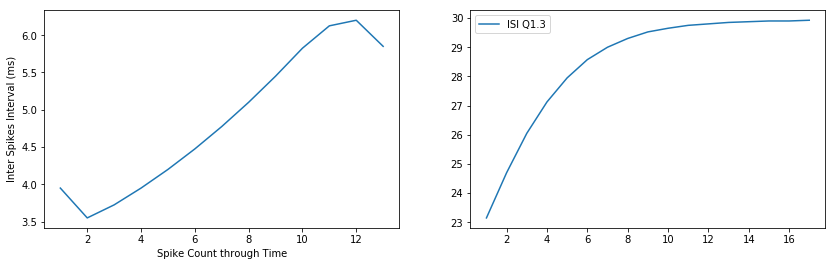

In [7]:
ISI = np.diff(spike_times)

C = len(spike_times)
x = np.arange(1, C, 1)

plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.plot(x, ISI / ms)
plt.xlabel('Spike Count through Time'), plt.ylabel('Inter Spikes Interval (ms)')

plt.subplot(1,2,2)
plt.plot(x_1_3, ISI_1_3 / ms, label = 'ISI Q1.3')
plt.legend()

##### This model spikes faster than LIF neuron (Q1.3.) In Wilson neuron the ISI steadily increases and then strats to decrease in last spikes. However, in LIF neuron the ISI asymptotically approaches a constant value. 

# Intro to BRIAN2 (compartmental models)

BRIAN2 also support multicompartment models (https://brian2.readthedocs.io/en/stable/user/multicompartmental.html).  In addition to defining the equations governing the membrane dynamics (i.e. ion channels), building a compartmental neuron requires specifying a morphology. To do this, we'll use BRIAN2's pre-built sections

In [54]:
soma = Soma(diameter=30*um)  # defines a sphere

Attach new sections to a previously defined section like so

In [55]:
soma.axon = Cylinder(length=100*um, diameter=1*um, n=10)  # n=10 compartments in this section
soma.dendrite = Cylinder(length=50*um, diameter=2*um, n=5)
soma.dendrite.branch1 = Cylinder(length=10*um, diameter=1*um, n=3)
soma.dendrite.branch2 = Cylinder(length=10*um, diameter=1*um, n=3)

Now we can define a SpatialNeuron according to our biophysical equations. BRIAN will automatically solve the cable equation between all the compartments, so specifying $\frac{dv}{dt}$ and $\frac{d^2v}{dx^2}$ is unnecessary: the user only needs to define the transmembrane and external currents. Notice that physical constants and state variables are now defined relative to space.

In [56]:
gL = 1e-4*siemens/cm**2  # leak conductance
Cm = 1*uF/cm**2  # membrane capacitance
Ri = 100*ohm*cm  # longitudinal (intracellular) resistivity
EL = -70*mV  # leak reversal potential

eqn = '''
Im = gL * (EL - v) : amp/meter**2  # total ionic (membrance) current
I : amp (point current)  # external current
# dv/dt, d2v/dx2, and I_long are calculated automatically
'''

neuron = SpatialNeuron(morphology=soma, model=eqn, Cm=Cm, Ri=Ri)

Set the membrane voltage of all compartments to -65mV, then apply an external current a few specific compartments. Note the use of ```.main``` to target a specific compartment

In [57]:
neuron.v = EL + 10*mV  # applies to state variables in soma compartment AND all connected compartments
neuron.main.v = EL + 10*mV  # applies to state variables in soma compartment
neuron.main.I[0] = 1*nA  # applies only to soma
neuron.dendrite.I[3] = 0.5*nA  # applies to a compartment part way down the dendrite
neuron.dendrite.branch1.I[1] = 0.5*nA

To detect spikes, we'll add a threshold condition. To ensure that multiple spikes don't get registered if this condition remains true for a while (e.g. v>v_thr), we'll also specify a refractory condition.

In [17]:
neuron = SpatialNeuron(morphology=soma, model=eqn,
    threshold='v > 0*mV',
    threshold_location=neuron.main[0],
    refractory='v > 0*mV',
    method="exponential_euler")

# Question 3: Hodgkin Huxley Neurons

A template for the Hodgkin-Huxley model is provided below, including various physical constants and a simple morphology. Note that voltage has been rescaled to $v_{rest} = 0$mV, and the equations for the gating variables have shifted accordingly.

## 3.1 [2 points] Implement the Hodgkin-Huxley model by filling in the provided template. Plot voltage vs time and $m$, $n$, and $h$ versus time for an external input of ```1uA``` applied over ```3ms```. 

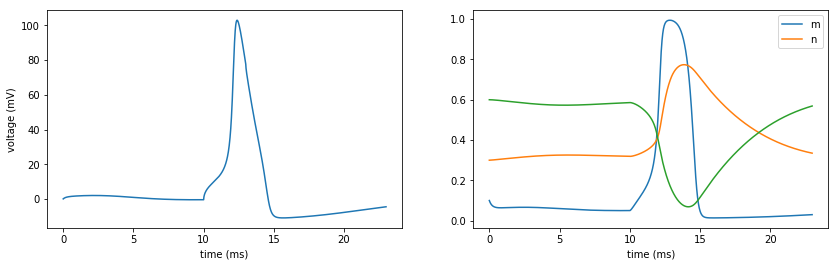

In [3]:
start_scope()

E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm

# Fill in these equations
eqn = '''
Im = g_na * m ** 3 * h * (E_na - v) + g_k * n ** 4 * (E_k - v) + g_leak * (E_leak - v)  : amp/meter**2
dm/dt = alpha_m * (1 - m) - beta_m * m : 1
dn/dt = alpha_n * (1 - n) - beta_n * n : 1
dh/dt = alpha_h * (1 - h) - beta_h * h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

neuron = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron.v = 0*mV
neuron.h = 0.6
neuron.m = 0.1
neuron.n = 0.3
defaultclock.dt = 0.01*ms

p_m = StateMonitor(neuron, 'm', record=True)
p_n = StateMonitor(neuron, 'n', record=True)
p_h = StateMonitor(neuron, 'h', record=True)
p_v = StateMonitor(neuron, 'v', record=True)

run(10*ms)
neuron.I[0] = 1*uA # current injection at one end of the axon
run(3*ms)
neuron.I = 0*uA
run(10*ms)

plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.plot(p_v.t / ms, p_v.v[0] / mV)
plt.xlabel('time (ms)'), plt.ylabel('voltage (mV)')

plt.subplot(1,2,2)
plt.plot(p_m.t / ms, p_m.m[0], label = 'm')
plt.plot(p_n.t / ms, p_n.n[0], label = 'n')
plt.plot(p_h.t / ms, p_h.h[0], label = '')
plt.xlabel('time (ms)'); 
plt.legend()

## 3.2 [0.5 point] Show that the action potential propagates down the cable with minimal attenuation.
- (a) plot voltage vs time at three points on the ```cable```: the left edge, center, and right edge.
- (b) increase the longitudinal resistance and show that the signal propagates slower. 

#### (a) plot voltage vs time at three points on the ```cable```: the left edge, center, and right edge.

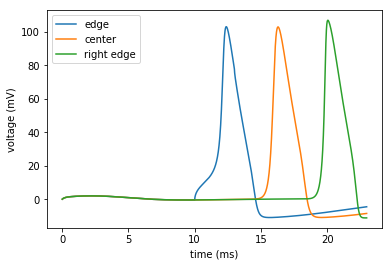

In [109]:
plt.plot(p_v.t / ms, p_v[0].v / mV, label = 'edge')
plt.plot(p_v.t / ms, p_v[499].v / mV, label = 'center')
plt.plot(p_v.t / ms, p_v[999].v / mV, label = 'right edge')
plt.xlabel('time (ms)'), plt.ylabel('voltage (mV)')
plt.legend()

#### (b) increase the longitudinal resistance and show that the signal propagates slower. 

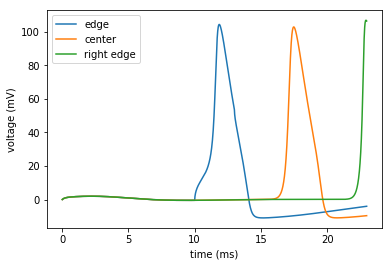

In [69]:
start_scope()

E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 2* 35.4*ohm*cm

# Fill in these equations
eqn = '''
Im = g_na * m ** 3 * h * (E_na - v) + g_k * n ** 4 * (E_k - v) + g_leak * (E_leak - v)  : amp/meter**2
dm/dt = alpha_m * (1 - m) - beta_m * m : 1
dn/dt = alpha_n * (1 - n) - beta_n * n : 1
dh/dt = alpha_h * (1 - h) - beta_h * h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

neuron = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron.v = 0*mV
neuron.h = 0.6
neuron.m = 0.1
neuron.n = 0.3
defaultclock.dt = 0.01*ms

p_v = StateMonitor(neuron, 'v', record=True)

run(10*ms)
neuron.I[0] = 1*uA # current injection at one end of the axon
run(3*ms)
neuron.I = 0*uA
run(10*ms)

plt.plot(p_v.t / ms, p_v[0].v / mV, label = 'edge')
plt.plot(p_v.t / ms, p_v[499].v / mV, label = 'center')
plt.plot(p_v.t / ms, p_v[999].v / mV, label = 'right edge')
plt.xlabel('time (ms)'), plt.ylabel('voltage (mV)')
plt.legend()

## 3.3 [0.5 point] Create a stimulus that produces a rebound spike, and plot the resulting voltage trace

(Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)'))

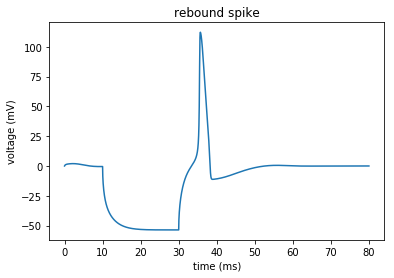

In [150]:
start_scope()

E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm

# Fill in these equations
eqn = '''
Im = g_na * m ** 3 * h * (E_na - v) + g_k * n ** 4 * (E_k - v) + g_leak * (E_leak - v)  : amp/meter**2
dm/dt = alpha_m * (1 - m) - beta_m * m : 1
dn/dt = alpha_n * (1 - n) - beta_n * n : 1
dh/dt = alpha_h * (1 - h) - beta_h * h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

neuron = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron.v = 0*mV
neuron.h = 0.6
neuron.m = 0.1
neuron.n = 0.3
defaultclock.dt = 0.01*ms

p_v = StateMonitor(neuron, 'v', record=True)

run(10*ms)
neuron.I[0] = -3*uA # current injection at one end of the axon
run(20*ms)
neuron.I = 0*uA
run(50*ms)

plt.plot(p_v.t / ms, p_v.v.T[:, 0] / mV)
plt.title('rebound spike')
plt.xlabel('time (ms)'), plt.ylabel('voltage (mV)')

## 3.4 [2 points] Create a new cell morphology that includes a soma and a dendritic tree with one branch. Show that voltage attenuation increases with the distance from the soma.
- Use ```Cylinder()``` for dendritic sections, with geometric parameters in these ranges:
 - ```length=10-100um```
 - ```diameter=0.1-1um```
 - ```n=5-100```
- Choose several points along the tree as injection sites.
- For each site, apply an identical external current ```I=100*pA``` and measure the resulting voltage change at the soma ($\Delta v = v_{rest} - v_{max}$).
- Plot $\Delta v$ vs distance. How does attenuation vary within a section and between sections (especially at branch points)?

In [2]:
start_scope()

E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm

# Fill in these equations
eqn = '''
Im = g_na * m ** 3 * h * (E_na - v) + g_k * n ** 4 * (E_k - v) + g_leak * (E_leak - v)  : amp/meter**2
dm/dt = alpha_m * (1 - m) - beta_m * m : 1
dn/dt = alpha_n * (1 - n) - beta_n * n : 1
dh/dt = alpha_h * (1 - h) - beta_h * h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

soma = Soma(diameter = 30 *um)
soma.d1 = Cylinder(length = 100 *um, diameter = 1 *um, n= 40)
soma.d1.d2 = Cylinder(length = 50 *um, diameter = 1 *um, n= 40)
soma.d1.d3 = Cylinder(length = 50 *um, diameter = 1 *um, n= 20)

neuron = SpatialNeuron(morphology=soma, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron.v = 0*mV
neuron.h = 0.6
neuron.m = 0.1
neuron.n = 0.3

p_v = StateMonitor(neuron, 'v', record=True)

store()

In [206]:
soma.topology()  

( )  [root] 
   `----------------------------------------|  .d1
                                             `----------------------------------------|  .d1.d2
                                             `--------------------|  .d1.d3

#### Injecting current at several points

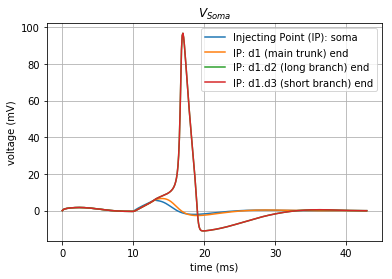

In [6]:
#applies only to soma
restore()
run(10 *ms)
neuron.main.I = 100 *pA  
run(3 *ms)
neuron.I = 0 *pA
run(30 *ms)

plt.plot(p_v.t / ms, p_v[0].v / mV, label = 'Injecting Point (IP): soma')
plt.xlabel('time (ms)'), plt.ylabel('voltage (mV)')

# applies to middle of d1
restore()
run(10 *ms)
neuron.d1.I[39] = 100 *pA  
run(3 *ms)
neuron.I = 0 *pA
run(30 *ms)

plt.plot(p_v.t / ms, p_v[0].v / mV, label = 'IP: d1 (main trunk) end')

# # applies to end of d2
restore()
run(10 *ms)
neuron.d1.d2.I[39] = 100 *pA  
run(3 *ms)
neuron.I = 0 *pA
run(30 *ms)

plt.plot(p_v.t / ms, p_v[0].v / mV, label = 'IP: d1.d2 (long branch) end')

# applies to end of d3
restore()
run(10 *ms)
neuron.d1.d3.I[19] = 100 *pA 
run(3 *ms)
neuron.I = 0 *pA
run(30 *ms)

plt.plot(p_v.t / ms, p_v[0].v / mV, label = 'IP: d1.d3 (short branch) end')
plt.legend()
plt.title(r'$V_{Soma}$')
plt.grid()

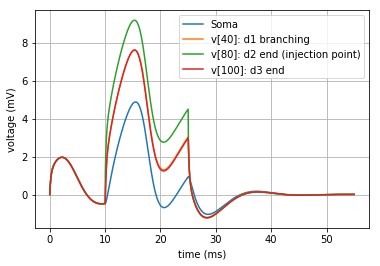

In [220]:
# applies to end of d2
restore()
run(10 *ms)
neuron.d1.d2.I[39] = 70 *pA  
run(15 *ms)
neuron.I = 0 *pA
run(30 *ms)

plt.plot(p_v.t / ms, p_v[0].v / mV, label = 'Soma')
plt.plot(p_v.t / ms, p_v[40].v / mV, label = 'v[40]: d1 branching')
plt.plot(p_v.t / ms, p_v[80].v / mV, label = 'v[80]: d2 end (injection point)')
plt.plot(p_v.t / ms, p_v[100].v / mV, label = 'v[100]: d3 end')
plt.xlabel('time (ms)'), plt.ylabel('voltage (mV)')
plt.legend()
plt.grid()

#### The voltage is highest at the point where the current is injected (here at the end of the dendrite.) As it propagates through the space its magnitude decreases. The lowest potential is recorded in the soma which is in the farthest location w.r.t injection point. 